In [50]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import time
import os
import uuid

In [51]:
def map_labels_to_numeric(labels):
    label_mapping = {'BENIGN': 0}
    numeric_labels = labels.apply(lambda x: 0 if 'BENIGN' in str(x) else 1)
    print(f"Nhãn sau khi ánh xạ: {numeric_labels.value_counts()}")
    return numeric_labels

In [52]:
def preprocess_data(data_path, features):
    data = pd.read_csv(data_path, low_memory=False)
    if ' Label' not in data.columns:
        raise ValueError("Cột 'Label' không tồn tại trong dữ liệu.")
    print(f"Nhãn trong dữ liệu: {data[' Label'].unique()}")
    print(f"[DEBUG] Tất cả các cột trong dữ liệu: {data.columns.tolist()}")
    missing_features = [f for f in features if f not in data.columns]
    if missing_features:
        print(f"[WARNING] Các đặc trưng không tồn tại trong dữ liệu: {missing_features}")
        features = [f for f in features if f in data.columns]
    if len(features) == 0:
        raise ValueError("Không có đặc trưng nào hợp lệ trong dữ liệu.")
    print(f"Đặc trưng được sử dụng sau khi kiểm tra: {features}")
    data = data.replace([np.inf, -np.inf], np.nan)
    data = data.dropna()
    numeric_labels = map_labels_to_numeric(data[' Label'])
    benign_data = data[data[' Label'].str.contains('BENIGN', case=False, na=False)][features]
    all_data = data[features]
    if benign_data.empty:
        raise ValueError("Không tìm thấy dữ liệu hợp lệ với nhãn 'Benign'.")
    print(f"[DEBUG] Số lượng mẫu trong benign_data: {len(benign_data)}")
    print(f"[DEBUG] Số lượng mẫu trong all_data: {len(all_data)}")
    non_numeric_cols = benign_data.select_dtypes(exclude=['float64', 'int64']).columns
    if len(non_numeric_cols) > 0:
        print(f"[WARNING] Loại bỏ các cột không phải số: {non_numeric_cols}")
        benign_data = benign_data.drop(columns=non_numeric_cols)
        all_data = all_data.drop(columns=non_numeric_cols)
    print(f"[DEBUG] Cột có phương sai thấp: {benign_data.columns[benign_data.var() <= 1e-3].tolist()}")
    benign_data = benign_data.loc[:, benign_data.var() > 1e-3]
    all_data = all_data[benign_data.columns]
    print(f"[DEBUG] Cột chứa NaN: {benign_data.columns[benign_data.isna().any()].tolist()}")
    benign_data = benign_data.dropna()
    all_data = all_data.dropna()
    numeric_labels = numeric_labels[all_data.index]
    if benign_data.empty:
        raise ValueError("DataFrame rỗng sau khi loại bỏ NaN.")
    selected_features = benign_data.columns.tolist()
    print(f"Number of features: {len(selected_features)}")
    scaler = MinMaxScaler()
    benign_data_scaled = scaler.fit_transform(benign_data)
    all_data_scaled = scaler.transform(all_data)
    print(f"[DEBUG] Giá trị lớn nhất sau chuẩn hóa: {benign_data_scaled.max(axis=0)}")
    print(f"[DEBUG] Giá trị nhỏ nhất sau chuẩn hóa: {benign_data_scaled.min(axis=0)}")
    train_data, test_data = train_test_split(benign_data_scaled, test_size=0.2, random_state=42)
    rus = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
    all_data_resampled, test_labels_resampled = rus.fit_resample(all_data_scaled, numeric_labels)
    print(f"Số lượng mẫu trong all_data_resampled: {len(all_data_resampled)}")
    print(f"Nhãn sau khi cân bằng: {pd.Series(test_labels_resampled).value_counts()}")
    return train_data, test_data, all_data_resampled, test_labels_resampled, scaler, selected_features

In [53]:
class DeepAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dims=[512, 256, 128, 16]):
        super(DeepAutoencoder, self).__init__()
        encoder_layers = []
        prev_dim = input_dim
        for dim in hidden_dims:
            encoder_layers.extend([
                nn.Linear(prev_dim, dim),
                nn.SELU(),
                nn.BatchNorm1d(dim),
                nn.Dropout(0.2)
            ])
            prev_dim = dim
        self.encoder = nn.Sequential(*encoder_layers)
        decoder_layers = []
        hidden_dims = hidden_dims[::-1]
        for dim in hidden_dims[:-1]:
            decoder_layers.extend([
                nn.Linear(prev_dim, dim),
                nn.SELU(),
                nn.BatchNorm1d(dim),
                nn.Dropout(0.2)
            ])
            prev_dim = dim
        decoder_layers.append(nn.Linear(prev_dim, input_dim))
        self.decoder = nn.Sequential(*decoder_layers)
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

In [54]:
def triplet_loss(encoded, labels, margin=1.0):
    benign = encoded[labels == 0]
    anomalous = encoded[labels == 1]
    if len(benign) < 2 or len(anomalous) < 1:
        return torch.tensor(0.0).to(encoded.device)
    anchor = benign
    positive = benign[torch.randperm(len(benign))[:len(anchor)]]
    negative = anomalous[torch.randint(0, len(anomalous), (len(anchor),))]
    distance_positive = F.pairwise_distance(anchor, positive)
    distance_negative = F.pairwise_distance(anchor, negative)
    losses = F.relu(distance_positive - distance_negative + margin)
    return losses.mean()

In [ ]:
def soft_triple_loss(encoded, labels, centers, lambda_param=1.0, gamma=0.1, delta=0.5):
    if len(encoded) == 0 or centers is None:
        return torch.tensor(0.0).to(encoded.device)
    
    K = 5 
    num_classes = 2  
    d = encoded.shape[1]  
    
    centers_benign = centers[0]  
    centers_anomalous = centers[1] 
    
    S_i_0 = torch.zeros(len(encoded)).to(encoded.device)  # Độ tương tự với lớp benign
    S_i_1 = torch.zeros(len(encoded)).to(encoded.device)  # Độ tương tự với lớp anomalous
    
    for i in range(len(encoded)):
        x_i = encoded[i].unsqueeze(0)  # [1, d]
        
        dot_products_benign = torch.matmul(x_i, centers_benign.transpose(0, 1))  # [1, K]
        weights_benign = F.softmax(dot_products_benign / gamma, dim=1)  # [1, K]
        S_i_0[i] = torch.sum(weights_benign * dot_products_benign)  # [1]
        
        dot_products_anomalous = torch.matmul(x_i, centers_anomalous.transpose(0, 1))  # [1, K]
        weights_anomalous = F.softmax(dot_products_anomalous / gamma, dim=1)  # [1, K]
        S_i_1[i] = torch.sum(weights_anomalous * dot_products_anomalous)  # [1]
    
    # Mất mát SoftTriple Loss
    S_i_yi = S_i_0.where(labels == 0, S_i_1.where(labels == 1, torch.tensor(0.0).to(encoded.device)))
    numerator = torch.exp(lambda_param * (S_i_yi - delta))
    denominator = numerator + torch.exp(lambda_param * S_i_1.where(labels == 0, S_i_0.where(labels == 1, torch.tensor(0.0).to(encoded.device))))
    loss = -torch.log(numerator / denominator + 1e-6) 
    
    return loss.mean()

In [56]:
def expand_dims(var, dim=0):
    sizes = list(var.size())
    sizes.insert(dim, 1)
    return var.view(*sizes)
def comparison_mask(a_labels, b_labels):
    return torch.eq(expand_dims(a_labels, 1), expand_dims(b_labels, 0)).float()
def dynamic_partition(X, partitions, n_clusters):
    indices = [torch.where(partitions == i)[0] for i in range(n_clusters)]
    return [X[idx] for idx in indices if len(idx) > 0]
def compute_euclidean_distance(x, y):
    return torch.sum((x - y)**2, dim=2)

In [57]:
def magnet_loss(encoded, labels, num_clusters=8, m=8, alpha=1.0, epsilon=1e-6, min_variance=1.0, max_dist=100.0, offset=1e-4):
    device = encoded.device
    batch_size = encoded.size(0)
    if batch_size < 2 or len(torch.unique(labels)) < 2:
        return torch.tensor(0.0).to(device)
    if torch.isnan(encoded).any() or torch.isinf(encoded).any():
        return torch.tensor(0.0).to(device)
    variance = max(torch.var(encoded, dim=0).mean().item(), min_variance) + epsilon
    var_normalizer = -1 / (2 * variance**2)
    benign = encoded[labels == 0]
    attack = encoded[labels == 1]
    if len(benign) < m or len(attack) < m:
        return torch.tensor(0.0).to(device)
    num_clusters = min(num_clusters, len(benign) // m, len(attack) // m)
    if num_clusters < 1:
        return torch.tensor(0.0).to(device)
    benign_indices = torch.randperm(len(benign), device=device)[:num_clusters * m]
    attack_indices = torch.randperm(len(attack), device=device)[:num_clusters * m]
    clusters = torch.arange(0, num_clusters, device=device).repeat_interleave(m)
    benign_clusters = benign[benign_indices]
    attack_clusters = attack[attack_indices]
    cluster_classes = torch.cat([torch.zeros(num_clusters, dtype=torch.long, device=device),
                                torch.ones(num_clusters, dtype=torch.long, device=device)])
    all_clusters = torch.cat([benign_clusters, attack_clusters], dim=0)
    cluster_examples = dynamic_partition(all_clusters, clusters, num_clusters)
    cluster_means = []
    valid_cluster_classes = []
    for i, x in enumerate(cluster_examples):
        if x.size(0) > 0:
            cluster_means.append(torch.mean(x, dim=0))
            valid_cluster_classes.append(cluster_classes[i])
    if not cluster_means:
        return torch.tensor(0.0).to(device)
    cluster_means = torch.stack(cluster_means)
    valid_cluster_classes = torch.tensor(valid_cluster_classes, device=device)
    sample_costs = compute_euclidean_distance(cluster_means, expand_dims(encoded, 1))
    sample_costs = torch.clamp(sample_costs, max=max_dist)
    intra_cluster_mask = comparison_mask(labels.type(torch.float), valid_cluster_classes.type(torch.float))
    intra_cluster_costs = torch.sum(intra_cluster_mask * sample_costs, dim=1)
    numerator = torch.exp(var_normalizer * intra_cluster_costs - alpha)
    diff_class_mask = 1 - comparison_mask(labels.type(torch.float), valid_cluster_classes.type(torch.float))
    denom_sample_costs = torch.exp(var_normalizer * sample_costs)
    denominator = torch.sum(diff_class_mask * denom_sample_costs, dim=1) + offset
    if torch.isnan(numerator).any() or torch.isnan(denominator).any() or (denominator <= epsilon).any():
        return torch.tensor(0.0).to(device)
    losses = F.relu(-torch.log(numerator / (denominator + epsilon) + epsilon))
    total_loss = torch.mean(losses)
    if torch.isnan(total_loss):
        return torch.tensor(0.0).to(device)
    return total_loss

In [58]:
def train_dae(model, train_loader, optimizer, scheduler, epochs=30, device='cuda', patience=10):
    model.train()
    losses = []
    best_loss = float('inf')
    patience_counter = 0
    for epoch in range(epochs):
        epoch_loss = 0
        for data, _ in train_loader:
            data = data.to(device)
            output, _ = model(data)
            recon_loss = nn.MSELoss()(data, output)
            optimizer.zero_grad()
            recon_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += recon_loss.item()
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        scheduler.step(avg_loss)
        print(f'Epoch [{epoch+1}/{epochs}], Reconstruction Loss: {avg_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_dae_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    return losses

In [59]:
def train_TDAE(model, train_loader, optimizer, scheduler, epochs=30, device='cuda', patience=10):
    model.train()
    losses = []
    best_loss = float('inf')
    patience_counter = 0
    for epoch in range(epochs):
        epoch_loss = 0
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            output, encoded = model(data)
            recon_loss = nn.MSELoss()(data, output)
            triplet = triplet_loss(encoded, labels)
            total_loss = recon_loss + triplet
            optimizer.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += total_loss.item()
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        scheduler.step(avg_loss)
        print(f'Epoch [{epoch+1}/{epochs}], Total Loss: {avg_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_TDAE_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    return losses

In [60]:
def train_DAE_soft_triplet(model, train_loader, optimizer, scheduler, epochs=30, device='cuda', patience=10, beta=1.0):
    model.train()
    losses = []
    best_loss = float('inf')
    patience_counter = 0
    for epoch in range(epochs):
        epoch_loss = 0
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            output, encoded = model(data)
            recon_loss = nn.MSELoss()(data, output)
            soft_triplet = soft_triplet_loss(encoded, labels, beta=beta)
            total_loss = recon_loss + soft_triplet
            optimizer.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += total_loss.item()
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        scheduler.step(avg_loss)
        print(f'Epoch [{epoch+1}/{epochs}], Total Loss: {avg_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_DAE_soft_triplet_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    return losses

In [61]:
def train_DMAE(model, train_loader, optimizer, scheduler, epochs=30, device='cuda', patience=20, alpha1=0.9, alpha2=0.01):
    model.train()
    losses = []
    best_loss = float('inf')
    patience_counter = 0
    for epoch in range(epochs):
        epoch_loss = 0
        batch_count = 0
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            output, encoded = model(data)
            recon_loss = nn.MSELoss()(data, output)
            if torch.isnan(encoded).any() or torch.isinf(encoded).any():
                total_loss = alpha1 * recon_loss
            else:
                magnet = magnet_loss(encoded, labels, num_clusters=8, m=8, alpha=1.0)
                if torch.isnan(magnet):
                    total_loss = alpha1 * recon_loss
                else:
                    total_loss = alpha1 * recon_loss + alpha2 * magnet
            if torch.isnan(total_loss):
                continue
            optimizer.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            epoch_loss += total_loss.item()
            batch_count += 1
        if batch_count == 0:
            continue
        avg_loss = epoch_loss / batch_count
        losses.append(avg_loss)
        scheduler.step(avg_loss)
        print(f'Epoch [{epoch+1}/{epochs}], Total Loss: {avg_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')
        if not torch.isnan(torch.tensor(avg_loss)) and avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_DMAE_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    return losses

In [62]:
def extract_features(model, data, device='cuda'):
    model.eval()
    data_tensor = torch.tensor(data, dtype=torch.float32).to(device)
    print(f"[DEBUG] Shape of input data in extract_features: {data_tensor.shape}")
    with torch.no_grad():
        _, encoded = model(data_tensor)
    print(f"[DEBUG] Shape of encoded features: {encoded.shape}")
    return encoded.cpu().numpy()

In [63]:
def evaluate_model(model, model_name, data, labels):
    start_time = time.time()
    if model_name == 'Linear Regression':
        predictions_proba = model.predict(data)
        predictions = (predictions_proba >= 0.5).astype(int)
    else:
        predictions = model.predict(data)
    training_time = time.time() - start_time
    cm = confusion_matrix(labels, predictions)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    precision = precision_score(labels, predictions, zero_division=0)
    recall = recall_score(labels, predictions, zero_division=0)
    f1 = f1_score(labels, predictions, zero_division=0)
    print(f"{model_name} - Precision: {precision:.4f}")
    print(f"{model_name} - Recall: {recall:.4f}")
    print(f"{model_name} - F1-score: {f1:.4f}")
    print(f"{model_name} - Confusion Matrix:\n{cm}")
    print(f"{model_name} - Số lượng bất thường phát hiện: {np.sum(predictions)}")
    print(f"{model_name} - Training time: {training_time:.2f} seconds")
    return precision, recall, f1, training_time, cm

In [64]:
def main():
    data_path = r'C:\Users\belon\Downloads\combine.csv\combine.csv'
    df1 = pd.read_csv(data_path)
    features = df1.columns.drop([' Label', ' Destination Port'])
    train_data, test_data, all_data_resampled, test_labels_resampled, scaler, selected_features = preprocess_data(data_path, features)
    if len(train_data) == 0 or len(test_data) == 0:
        raise ValueError("Dữ liệu huấn luyện hoặc kiểm tra rỗng.")
    input_dim = len(selected_features)
    print(f"Selected features: {selected_features}")
    print(f"[DEBUG] Input dimension for DAE/TDAE/DMAE: {input_dim}")
    print(f"[DEBUG] Shape of all_data_resampled: {all_data_resampled.shape}")
    all_data_tensor = torch.tensor(all_data_resampled, dtype=torch.float32)
    labels_tensor = torch.tensor(test_labels_resampled.values, dtype=torch.long)
    dataset_all = torch.utils.data.TensorDataset(all_data_tensor, labels_tensor)
    train_loader_all = torch.utils.data.DataLoader(dataset_all, batch_size=2048, shuffle=True, num_workers=4)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    models = {
        'Linear Regression': LinearRegression(),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Decision Tree': DecisionTreeClassifier(random_state=42)
    }
    results = []
    print("\nTraining DAE...")
    dae = DeepAutoencoder(input_dim=input_dim).to(device)
    optimizer_dae = torch.optim.Adam(dae.parameters(), lr=0.0001)
    scheduler_dae = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_dae, mode='min', factor=0.5, patience=10)
    start_time = time.time()
    losses_dae = train_dae(dae, train_loader_all, optimizer_dae, scheduler_dae, epochs=30, device=device)
    dae_time = time.time() - start_time
    plt.plot(losses_dae)
    plt.xlabel('Epoch')
    plt.ylabel('Reconstruction Loss')
    plt.title('DAE Training Loss (16 Dimensions)')
    plt.show()
    dae.load_state_dict(torch.load('best_dae_model.pth'))
    dae_features = extract_features(dae, all_data_resampled, device)
    train_features_dae, test_features_dae, train_labels_dae, test_labels_dae = train_test_split(
        dae_features, test_labels_resampled, test_size=0.2, random_state=42, stratify=test_labels_resampled
    )
    for model_name, model in models.items():
        print(f"\nEvaluating {model_name} with DAE features...")
        start_time = time.time()
        model.fit(train_features_dae, train_labels_dae)
        training_time = time.time() - start_time
        precision, recall, f1, _, cm = evaluate_model(model, model_name, test_features_dae, test_labels_dae)
        results.append({
            'Method': 'DAE',
            'Model': model_name,
            'Precision': precision,
            'Recall': recall,
            'F1-score': f1,
            'Training Time (s)': training_time
        })
    print("\nApplying PCA to DAE features...")
    pca = PCA(n_components=16, random_state=42)
    dae_pca_features = pca.fit_transform(dae_features)
    train_features_pca, test_features_pca, train_labels_pca, test_labels_pca = train_test_split(
        dae_pca_features, test_labels_resampled, test_size=0.2, random_state=42, stratify=test_labels_resampled
    )
    for model_name, model in models.items():
        print(f"\nEvaluating {model_name} with DAE+PCA features...")
        start_time = time.time()
        model.fit(train_features_pca, train_labels_pca)
        training_time = time.time() - start_time
        precision, recall, f1, _, cm = evaluate_model(model, model_name, test_features_pca, test_labels_pca)
        results.append({
            'Method': 'DAE+PCA',
            'Model': model_name,
            'Precision': precision,
            'Recall': recall,
            'F1-score': f1,
            'Training Time (s)': training_time
        })
    print("\nTraining TDAE...")
    TDAE = DeepAutoencoder(input_dim=input_dim).to(device)
    optimizer_TDAE = torch.optim.Adam(TDAE.parameters(), lr=0.0001)
    scheduler_TDAE = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_TDAE, mode='min', factor=0.5, patience=10)
    start_time = time.time()
    losses_TDAE = train_TDAE(TDAE, train_loader_all, optimizer_TDAE, scheduler_TDAE, epochs=30, device=device)
    TDAE_time = time.time() - start_time
    plt.plot(losses_TDAE)
    plt.xlabel('Epoch')
    plt.ylabel('Total Loss')
    plt.title('TDAE Training Loss (16 Dimensions)')
    plt.show()
    TDAE.load_state_dict(torch.load('best_TDAE_model.pth'))
    TDAE_features = extract_features(TDAE, all_data_resampled, device)
    train_features_TDAE, test_features_TDAE, train_labels_TDAE, test_labels_TDAE = train_test_split(
        TDAE_features, test_labels_resampled, test_size=0.2, random_state=42, stratify=test_labels_resampled
    )
    for model_name, model in models.items():
        print(f"\nEvaluating {model_name} with TDAE features...")
        start_time = time.time()
        model.fit(train_features_TDAE, train_labels_TDAE)
        training_time = time.time() - start_time
        precision, recall, f1, _, cm = evaluate_model(model, model_name, test_features_TDAE, test_labels_TDAE)
        results.append({
            'Method': 'TDAE',
            'Model': model_name,
            'Precision': precision,
            'Recall': recall,
            'F1-score': f1,
            'Training Time (s)': training_time
        })
    print("\nTraining DAE with Soft Triplet Loss...")
    DAE_soft_triplet = DeepAutoencoder(input_dim=input_dim).to(device)
    optimizer = torch.optim.Adam(DAE_soft_triplet.parameters(), lr=0.0001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
    start_time = time.time()
    losses = train_DAE_soft_triplet(DAE_soft_triplet, train_loader_all, optimizer, scheduler, epochs=30, device=device, beta=1.0)
    soft_triplet_time = time.time() - start_time
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Total Loss')
    plt.title('DAE with Soft Triplet Loss Training Loss (16 Dimensions)')
    plt.show()
    DAE_soft_triplet.load_state_dict(torch.load('best_DAE_soft_triplet_model.pth'))
    soft_triplet_features = extract_features(DAE_soft_triplet, all_data_resampled, device)
    train_features_soft_triplet, test_features_soft_triplet, train_labels_soft_triplet, test_labels_soft_triplet = train_test_split(
        soft_triplet_features, test_labels_resampled, test_size=0.2, random_state=42, stratify=test_labels_resampled
    )
    for model_name, model in models.items():
        print(f"\nEvaluating {model_name} with DAE+Soft Triplet features...")
        start_time = time.time()
        model.fit(train_features_soft_triplet, train_labels_soft_triplet)
        training_time = time.time() - start_time
        precision, recall, f1, _, cm = evaluate_model(model, model_name, test_features_soft_triplet, test_labels_soft_triplet)
        results.append({
            'Method': 'DAE+Soft Triplet',
            'Model': model_name,
            'Precision': precision,
            'Recall': recall,
            'F1-score': f1,
            'Training Time (s)': training_time
        })
    print("\nTraining DMAE...")
    DMAE = DeepAutoencoder(input_dim=input_dim).to(device)
    optimizer_DMAE = torch.optim.Adam(DMAE.parameters(), lr=0.0001, betas=(0.9, 0.999))
    scheduler_DMAE = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_DMAE, mode='min', factor=0.5, patience=10)
    start_time = time.time()
    losses_DMAE = train_DMAE(DMAE, train_loader_all, optimizer_DMAE, scheduler_DMAE, epochs=30, device=device, alpha1=0.9, alpha2=0.01)
    DMAE_time = time.time() - start_time
    plt.plot(losses_DMAE)
    plt.xlabel('Epoch')
    plt.ylabel('Total Loss')
    plt.title('DMAE Training Loss')
    plt.show()
    if os.path.exists('best_DMAE_model.pth'):
        DMAE.load_state_dict(torch.load('best_DMAE_model.pth', map_location=device))
    DMAE_features = extract_features(DMAE, all_data_resampled, device)
    train_features_DMAE, test_features_DMAE, train_labels_DMAE, test_labels_DMAE = train_test_split(
        DMAE_features, test_labels_resampled, test_size=0.2, random_state=42, stratify=test_labels_resampled
    )
    for model_name, model in models.items():
        print(f"\nEvaluating {model_name} with DMAE features...")
        start_time = time.time()
        model.fit(train_features_DMAE, train_labels_DMAE)
        training_time = time.time() - start_time
        precision, recall, f1, _, cm = evaluate_model(model, model_name, test_features_DMAE, test_labels_DMAE)
        results.append({
            'Method': 'DMAE',
            'Model': model_name,
            'Precision': precision,
            'Recall': recall,
            'F1-score': f1,
            'Training Time (s)': training_time
        })
    torch.save(dae.state_dict(), 'dae_model_16dims.pth')
    torch.save(TDAE.state_dict(), 'TDAE_model_16dims.pth')
    torch.save(DAE_soft_triplet.state_dict(), 'DAE_soft_triplet_model_16dims.pth')
    torch.save(DMAE.state_dict(), 'DMAE_model_16dims.pth')
    print(f"Thời gian huấn luyện DAE: {dae_time:.2f} giây")
    print(f"Thời gian huấn luyện TDAE: {TDAE_time:.2f} giây")
    print(f"Thời gian huấn luyện DAE+Soft Triplet: {soft_triplet_time:.2f} giây")
    print(f"Thời gian huấn luyện DMAE: {DMAE_time:.2f} giây")
    results_df = pd.DataFrame(results)
    for model_name in models.keys():
        model_results = results_df[results_df['Model'] == model_name]
        markdown_table = f"# So sánh hiệu suất của {model_name}\n\n"
        markdown_table += "| Phương pháp | Precision | Recall | F1-score | Thời gian huấn luyện (s) |\n"
        markdown_table += "|------------|-----------|--------|----------|-------------------------|\n"
        for _, row in model_results.iterrows():
            markdown_table += f"| {row['Method']} | {row['Precision']:.4f} | {row['Recall']:.4f} | {row['F1-score']:.4f} | {row['Training Time (s)']:.2f} |\n"
        print(markdown_table)
        with open(f'comparison_results_{model_name.lower().replace(" ", "_")}.md', 'w', encoding='utf-8') as f:
            f.write(markdown_table)
    return results_df

C:\Users\belon\AppData\Local\Temp\ipykernel_14108\652597298.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv(data_path)


Nhãn trong dữ liệu: ['BENIGN' 'DDoS' 'PortScan' 'Bot' 'Infiltration' 'DoS slowloris'
 'DoS Slowhttptest' 'DoS Hulk' 'DoS GoldenEye' 'Heartbleed' nan]
[DEBUG] Tất cả các cột trong dữ liệu: [' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packe

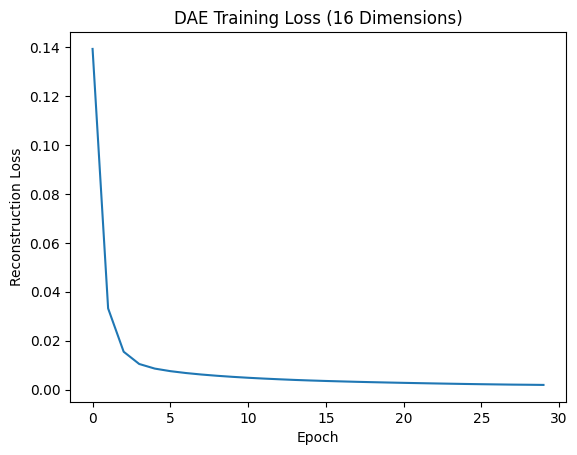

C:\Users\belon\AppData\Local\Temp\ipykernel_14108\652597298.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dae.load_state_dict(torch.load('best_dae_model.pth'))


[DEBUG] Shape of input data in extract_features: torch.Size([1081092, 65])
[DEBUG] Shape of encoded features: torch.Size([1081092, 16])

Evaluating Linear Regression with DAE features...
Linear Regression - Precision: 0.8302
Linear Regression - Recall: 0.6582
Linear Regression - F1-score: 0.7342
Linear Regression - Confusion Matrix:
[[93555 14555]
 [36955 71154]]
Linear Regression - Số lượng bất thường phát hiện: 85709
Linear Regression - Training time: 0.00 seconds

Evaluating Gradient Boosting with DAE features...
Gradient Boosting - Precision: 0.9649
Gradient Boosting - Recall: 0.9811
Gradient Boosting - F1-score: 0.9729
Gradient Boosting - Confusion Matrix:
[[104247   3863]
 [  2043 106066]]
Gradient Boosting - Số lượng bất thường phát hiện: 109929
Gradient Boosting - Training time: 0.34 seconds

Evaluating Logistic Regression with DAE features...
Logistic Regression - Precision: 0.8192
Logistic Regression - Recall: 0.6569
Logistic Regression - F1-score: 0.7291
Logistic Regression 

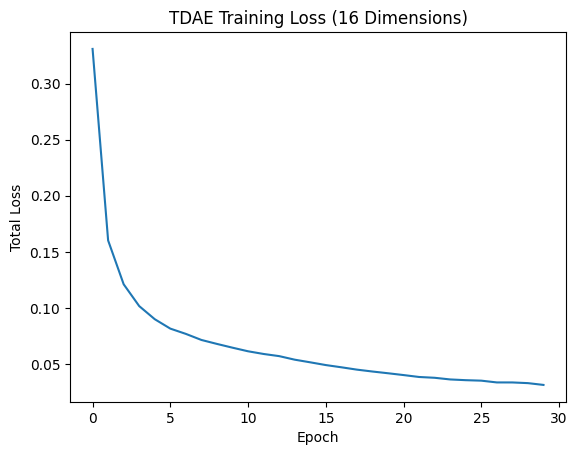

C:\Users\belon\AppData\Local\Temp\ipykernel_14108\652597298.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  TDAE.load_state_dict(torch.load('best_TDAE_model.pth'))


[DEBUG] Shape of input data in extract_features: torch.Size([1081092, 65])
[DEBUG] Shape of encoded features: torch.Size([1081092, 16])

Evaluating Linear Regression with TDAE features...
Linear Regression - Precision: 0.9659
Linear Regression - Recall: 0.8797
Linear Regression - F1-score: 0.9208
Linear Regression - Confusion Matrix:
[[104757   3353]
 [ 13008  95101]]
Linear Regression - Số lượng bất thường phát hiện: 98454
Linear Regression - Training time: 0.00 seconds

Evaluating Gradient Boosting with TDAE features...
Gradient Boosting - Precision: 0.9747
Gradient Boosting - Recall: 0.9938
Gradient Boosting - F1-score: 0.9842
Gradient Boosting - Confusion Matrix:
[[105326   2784]
 [   674 107435]]
Gradient Boosting - Số lượng bất thường phát hiện: 110219
Gradient Boosting - Training time: 0.28 seconds

Evaluating Logistic Regression with TDAE features...
Logistic Regression - Precision: 0.9577
Logistic Regression - Recall: 0.9652
Logistic Regression - F1-score: 0.9614
Logistic Regr

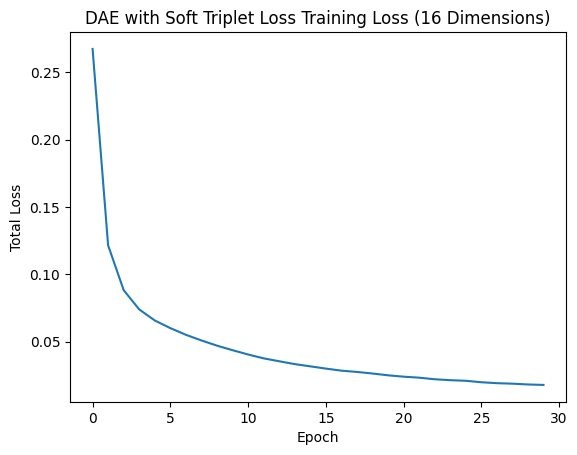

C:\Users\belon\AppData\Local\Temp\ipykernel_14108\652597298.py:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  DAE_soft_triplet.load_state_dict(torch.load('best_DAE_soft_

[DEBUG] Shape of input data in extract_features: torch.Size([1081092, 65])
[DEBUG] Shape of encoded features: torch.Size([1081092, 16])

Evaluating Linear Regression with DAE+Soft Triplet features...
Linear Regression - Precision: 0.9706
Linear Regression - Recall: 0.9223
Linear Regression - F1-score: 0.9458
Linear Regression - Confusion Matrix:
[[105093   3017]
 [  8403  99706]]
Linear Regression - Số lượng bất thường phát hiện: 102723
Linear Regression - Training time: 0.00 seconds

Evaluating Gradient Boosting with DAE+Soft Triplet features...
Gradient Boosting - Precision: 0.9764
Gradient Boosting - Recall: 0.9951
Gradient Boosting - F1-score: 0.9856
Gradient Boosting - Confusion Matrix:
[[105505   2605]
 [   531 107578]]
Gradient Boosting - Số lượng bất thường phát hiện: 110183
Gradient Boosting - Training time: 0.27 seconds

Evaluating Logistic Regression with DAE+Soft Triplet features...
Logistic Regression - Precision: 0.9586
Logistic Regression - Recall: 0.9869
Logistic Regres

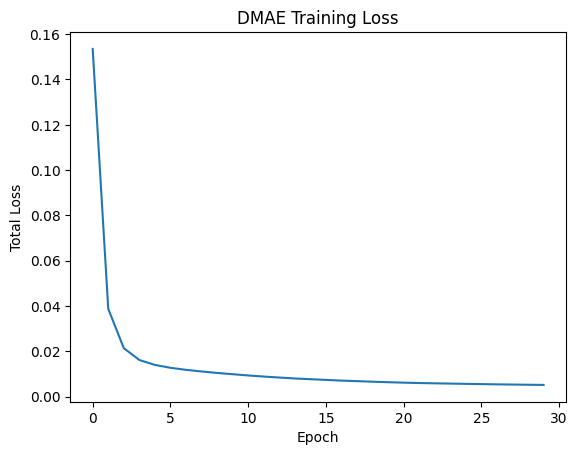

C:\Users\belon\AppData\Local\Temp\ipykernel_14108\652597298.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  DMAE.load_state_dict(torch.load('best_DMAE_model.pth', map_

[DEBUG] Shape of input data in extract_features: torch.Size([1081092, 65])
[DEBUG] Shape of encoded features: torch.Size([1081092, 16])

Evaluating Linear Regression with DMAE features...
Linear Regression - Precision: 0.9564
Linear Regression - Recall: 0.8727
Linear Regression - F1-score: 0.9126
Linear Regression - Confusion Matrix:
[[103807   4303]
 [ 13763  94346]]
Linear Regression - Số lượng bất thường phát hiện: 98649
Linear Regression - Training time: 0.01 seconds

Evaluating Gradient Boosting with DMAE features...
Gradient Boosting - Precision: 0.9770
Gradient Boosting - Recall: 0.9915
Gradient Boosting - F1-score: 0.9842
Gradient Boosting - Confusion Matrix:
[[105582   2528]
 [   919 107190]]
Gradient Boosting - Số lượng bất thường phát hiện: 109718
Gradient Boosting - Training time: 0.30 seconds

Evaluating Logistic Regression with DMAE features...
Logistic Regression - Precision: 0.9537
Logistic Regression - Recall: 0.9780
Logistic Regression - F1-score: 0.9657
Logistic Regr

In [65]:
results_df = main()